<a href="https://colab.research.google.com/github/Schimmenti/EarthquakesGPS/blob/main/Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import time


In [22]:
def haversine(lat1, lat2, delta_long):
  return np.sin((lat2-lat1)/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin(delta_long/2)**2

In [3]:
def moving_lin_regress(x, T, t0, t1):
    m = []
    for t in range(t0,t1-T):
        m.append(stats.linregress(np.arange(0,T),x[t:t+T])[0])
    return np.array(m)

In [4]:
base_link = "https://raw.githubusercontent.com/Schimmenti/EarthquakesGPS/main/gps_data/"

In [5]:
! wget "https://raw.githubusercontent.com/Schimmenti/EarthquakesGPS/main/gps_data/stat_info.pkl"

--2022-03-05 16:42:53--  https://raw.githubusercontent.com/Schimmenti/EarthquakesGPS/main/gps_data/stat_info.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17030 (17K) [application/octet-stream]
Saving to: ‘stat_info.pkl’

stat_info.pkl       100%[===================>]  16.63K  --.-KB/s    in 0.001s  

2022-03-05 16:42:53 (22.3 MB/s) - ‘stat_info.pkl’ saved [17030/17030]



In [6]:
with open("stat_info.pkl","rb") as handle:
  station_names, station_pos = pkl.load(handle)

In [7]:
stat_data = {}
for name in station_names:
  try:
    stat_data[name] = pd.read_csv(base_link + name + ".csv")
  except:
    continue

In [8]:
for name in stat_data.keys():
  #decimal_years  = stat_data[name]["DateD"].values
  #years = np.trunc(decimal_years).astype('int')
  #days_in_year = 365*np.ones(len(years), dtype=int)
  #days_in_year[days_in_year%4==0] += 1
  #days = np.round((decimal_years-years)*days_in_year).astype('int')
  #starting_date = datetime.date(years[0], 1, 1)
  #delta_days = datetime.timedelta(int(days[0]) - 1)
  #starting_date += delta_days
#
  #ending_date = datetime.date(years[-1]-1, 12, 31)
  #delta_days = datetime.timedelta(int(days[-1]))
  #ending_date += delta_days
  #print(ending_date)
  #del stat_data[name]["Date"]

  stat_data[name]['Date'] = pd.to_datetime(stat_data[name]['DateI'], format='%Y%m%d')
  stat_data[name].set_index("Date", drop=True, inplace=True)
  idx = pd.date_range(stat_data[name].index[0], stat_data[name].index[-1])
  stat_data[name] = stat_data[name].reindex(idx, fill_value=np.NaN)

In [9]:
stat_data['501p']

,DateI,DateD,N,E,U,Tech1,dN,dE,dU,Tech2,Descr
2005-04-01,20050401.0,2005.2493,16.0,-2.8,-2.2,rrr,2.5,2.9,8.4,0.0483,Southern_California.20050401.stacov.point-2016...
2005-04-02,20050402.0,2005.2521,16.1,-3.9,-1.9,rrr,2.5,2.8,8.4,0.0548,Southern_California.20050402.stacov.point-2016...
2005-04-03,20050403.0,2005.2547,14.3,-3.0,-3.9,rrr,2.7,3.0,9.3,0.0781,Southern_California.20050403.stacov.point-2016...
2005-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-13,20220113.0,2022.0354,10.9,-7.4,3.8,ppp,2.6,3.2,9.3,0.0306,Southern_California.20220113.stacov.point-2022...
2022-01-14,20220114.0,2022.0382,10.2,-8.5,6.1,ppp,2.6,3.2,9.3,0.0408,Southern_California.20220114.stacov.point-2022...
2022-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-16,20220116.0,2022.0437,9.9,-8.9,-7.0,ppp,2.6,3.2,9.3,0.0385,Southern_California.20220116.stacov.point-2022...


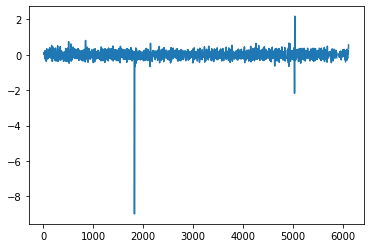

In [10]:
W=9
for name in stat_data.keys():
  nord = stat_data[name]["N"].values
  T_w_nord = moving_lin_regress(nord, W, 0, len(nord))
  east = stat_data[name]["E"].values
  T_w_east = moving_lin_regress(east, W, 0, len(east))
  up = stat_data[name]["U"].values
  T_w_up = moving_lin_regress(up, W, 0, len(up))
  plt.plot(T_w_nord)
  plt.show()
  break

# Catalog

In [11]:
catalog = pd.read_csv("https://raw.githubusercontent.com/Schimmenti/EarthquakesGPS/main/hauksson_relocated.dat",sep=r"\s+",header=None)
catalog.columns = ["sec","m","lat","long","dep"]

In [12]:
landers = catalog[catalog["m"]==7.3]
landers_date = datetime.date(1992,6,28)
landers_time = datetime.timedelta(hours=11, minutes=57, seconds=33)
delta_time = datetime.timedelta(seconds=float(landers['sec'].values))
catalog_beginning = landers_date+landers_time-delta_time
catalog_seconds = catalog['sec'].values.astype('timedelta64[s]')
start_date = np.datetime64(catalog_beginning)
catalog_dates = start_date + catalog_seconds
year_integer =  catalog_dates.astype('datetime64[Y]').astype('int')+1970
month_integer =  catalog_dates.astype('datetime64[M]').astype('int')%12+1
day_integer = (catalog_dates- catalog_dates.astype('datetime64[M]') + 1).astype('timedelta64[D]').astype('int')+1
date_integer =(year_integer*10000+month_integer*100+day_integer)
pandas_datetime = pd.to_datetime(date_integer, format='%Y%m%d')
catalog["Date"] = pandas_datetime
catalog.set_index("Date", drop=True, inplace=True)

In [13]:
catalog.to_csv("catalog.csv", sep="\t")

# Station position

In [27]:
position_array = np.array([station_pos[key] for key in stat_data.keys()])

In [28]:
lat1 = catalog['lat'].values.reshape(-1,1)
lat2 = position_array[:,0].reshape(1,-1)
delta_long = catalog['long'].values.reshape(-1,1)-position_array[:,1].reshape(1,-1)

In [ ]:
distances = haversine(lat1,lat2,delta_long)

In [25]:
closest_station_idx = np.argmin(distances, axis=1)

In [26]:
closest_station_anme = 

array([380, 188, 143, ..., 262,  67, 220])

In [12]:
m_day = catalog["m"].groupby("Date").apply(lambda x : (2/3)*np.log10(np.sum(10**(1.5*x))))
true_days = m_day.index
m_day = m_day.values
lat_day = catalog["lat"].groupby("Date").mean().values
long_day = catalog["long"].groupby("Date").mean().values
dep_day = catalog["dep"].groupby("Date").mean().values

In [13]:
catalog_day = pd.DataFrame(columns = ["m", "lat", "long", "dep" ])

In [14]:
catalog_day["m"] = m_day
catalog_day["lat"] = lat_day
catalog_day["long"] = long_day
catalog_day["dep"] = dep_day
catalog_day.index = true_days

In [15]:
catalog_day.to_csv("catalog_day.csv", sep="\t")